<a href="https://colab.research.google.com/github/JaleelSavoy/DeepLearningPracticeProjects/blob/master/PredictingDota2MatchOutcomes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Predicting Dota 2 Match Outcomes**
### **Jaleel Walter Henry Savoy**

# Introduction
The objective of this project was to create a deep learning model that would learn to predict Dota 2 match outcomes from only the match details. The implemented deep learning model is able to predict match outcomes at an accuracy that is 20% greater than the uniformly random benchmark. Additionally, the model matches the performance of a paper with similar goals despite the fact that this model knows nothing of the players' historical performances, while the paper's model is train on data which includes that information.

# Data
The match details data was collected from games played during a two-hour period on August 13th, 2016 by Stephen Tridgell using the open-source software, dota2api. The dataset has the following independent variables: region cluster ID, game mode, lobby type, and 113 indicator variables for in-game characters. Check out the UCI Data Repository link and the Dota 2 API documentation link to get more information on the data. 


### Relevant Links

* [The Data](https://archive.ics.uci.edu/ml/datasets/Dota2+Games+Results)

* [The Encoding Dictionary for the Hero Indicator Columns](https://raw.githubusercontent.com/kronusme/dota2-api/master/data/heroes.json)

* [The Dota2 API](https://readthedocs.org/projects/demodota2api/downloads/pdf/latest/)

* [Paper on Predicting Dota 2 Matches](http://cs229.stanford.edu/proj2017/final-reports/5233394.pdf)

# Results:

The model surpasses the benchmark that essentially boils down to chance by achieveing an overall accuracy of about 60% on the validation set while the benchmark of uniformly random chance did not surpass 50%. Additionally, the model from the Stanford students' paper also tops out at about 60%.

Deep Neural Network Model Results:

| Class | Precision | Recall | F1-Score | Support |
| --- | --- | --- | --- | --- |
| Lose | 0.58 | 0.48 | 0.52 | 4792 |
| Win | 0.61 | 0.70 | 0.65 | 5502 |
| --- | --- | --- | --- | --- |
| Accuracy | --- | --- | --- | 0.60

Uniformly Random Dummy Classifer Benchmark:

| Class | Precision | Recall | F1-Score | Support |
| --- | --- | --- | --- | --- |
| Lose | 0.46 | 0.49 | 0.47 | 4792 |
| Win | 0.53 | 0.50 | 0.51 | 5502 |
| --- | --- | --- | --- | --- |
| Accuracy | --- | --- | --- | 0.49


# The Code

In [0]:
## Relevant Imports
import numpy as np, pandas as pd, random, keras
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.dummy import DummyClassifier

import io
import json
import urllib.request
import zipfile

import os, random, tensorflow as tf
os.environ['PYTHONHASHSEED']=str(123)
random.seed(123)
np.random.seed(123)
tf.random.set_random_seed(123)

import pickle
from google.colab import files

In [0]:
## Load and prep the data
# Initial Column Headers
col_names = ['Game_Outcome', 'Region_ID', 'Game_Mode', 'Lobby_Type'] + list(np.arange(1,114,1))

# Game Modes Decoding
game_modes = ['Unknown','All Pick', 'CaptainsMode', 'RandomDraft', 'SingleDraft', 'AllRandom',
              'Intro', 'Diretide', 'ReverseCaptainsMode', 'TheGreeviling']

# Lobby Types Decoding
lobby_types = ['Public','Practice', 'Tournament', 'Tutorial']

# Get the Match Data
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00367/dota2Dataset.zip'
url = urllib.request.urlopen(url)
zippedfile = zipfile.ZipFile(io.BytesIO(url.read()))
train_data = pd.read_csv(zippedfile.open('dota2Train.csv'), header=None, names=col_names)
test_data = pd.read_csv(zippedfile.open('dota2Test.csv'), header=None, names=col_names)

# Get the Character Names and Rename the columns
url2 = 'https://raw.githubusercontent.com/kronusme/dota2-api/master/data/heroes.json'
req = urllib.request.urlopen(url2).read()
json_data = dict(json.loads(req.decode('utf-8')))
names = (pd.DataFrame(json_data['heroes'])[['id', 'name']]).set_index('id').to_dict()['name']
train_data.rename(columns=train_data.columns[4:].to_series().map(names), inplace=True)
test_data.rename(columns=test_data.columns[4:].to_series().map(names), inplace=True)

# Get the Region Cluster Decodings
url3 = 'https://raw.githubusercontent.com/kronusme/dota2-api/master/data/regions.json'
req2 = urllib.request.urlopen(url3).read()
json_data2 = dict(json.loads(req2.decode('utf-8')))
regions = (pd.DataFrame(json_data2['regions'])[['id', 'name']]).set_index('id').to_dict()['name']

In [0]:
train_data['Game_Outcome'] = train_data['Game_Outcome'].replace(-1, 0)
test_data['Game_Outcome'] = test_data['Game_Outcome'].replace(-1, 0)

Model: "model_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 116)               0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 64)                7488      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 64)                4160      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 64)                4160      
_________________________________________________________________
hidden_layer4 (Dense)        (None, 64)                4160      
_________________________________________________________________
hidden_layer5 (Dense)        (None, 64)                4160      
_________________________________________________________________
hidden_layer6 (Dense)        (None, 64)                416

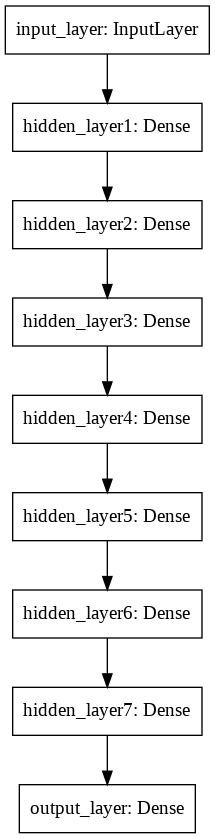

In [184]:
## Build the Deep Learning Model
predictors = list(train_data.loc[:, train_data.columns != 'Game_Outcome'].columns.values)
train_data[predictors]
response = 'Game_Outcome'
input_layer = keras.layers.Input(shape=(train_data[predictors].shape[1],), name='input_layer')

hidden_layer1 = keras.layers.Dense(units=64, activation='relu', name='hidden_layer1')(input_layer)
hidden_layer2 = keras.layers.Dense(units=64, activation='relu', name='hidden_layer2')(hidden_layer1)
hidden_layer3 = keras.layers.Dense(units=64, activation='relu', name='hidden_layer3')(hidden_layer2)
hidden_layer4 = keras.layers.Dense(units=64, activation='relu', name='hidden_layer4')(hidden_layer3)
hidden_layer5 = keras.layers.Dense(units=64, activation='relu', name='hidden_layer5')(hidden_layer4)
hidden_layer6 = keras.layers.Dense(units=64, activation='relu', name='hidden_layer6')(hidden_layer5)
hidden_layer7 = keras.layers.Dense(units=64, activation='relu', name='hidden_layer7')(hidden_layer6)

output_layer = keras.layers.Dense(1, activation='sigmoid', name='output_layer')(hidden_layer7)
model = keras.Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=keras.optimizers.adadelta(), loss='binary_crossentropy', metrics=['accuracy'])

print(model.summary())
keras.utils.plot_model(model)

In [185]:
## Fit the Deep Learning Model
history = model.fit(train_data[predictors], train_data[response],
          epochs=50, batch_size=512, shuffle=True,
          validation_data=(test_data[predictors], test_data[response]), verbose=1)

Train on 92650 samples, validate on 10294 samples
Epoch 1/50
92650/92650 [==============================] - 9s 94us/step - loss: 0.7140 - acc: 0.5155 - val_loss: 0.6906 - val_acc: 0.5345
Epoch 2/50
92650/92650 [==============================] - 2s 17us/step - loss: 0.6937 - acc: 0.5182 - val_loss: 0.6923 - val_acc: 0.5426
Epoch 3/50
92650/92650 [==============================] - 2s 17us/step - loss: 0.6925 - acc: 0.5231 - val_loss: 0.6900 - val_acc: 0.5345
Epoch 4/50
92650/92650 [==============================] - 2s 17us/step - loss: 0.6920 - acc: 0.5238 - val_loss: 0.6916 - val_acc: 0.5345
Epoch 5/50
92650/92650 [==============================] - 2s 18us/step - loss: 0.6913 - acc: 0.5247 - val_loss: 0.6889 - val_acc: 0.5346
Epoch 6/50
92650/92650 [==============================] - 2s 17us/step - loss: 0.6911 - acc: 0.5271 - val_loss: 0.6958 - val_acc: 0.5345
Epoch 7/50
92650/92650 [==============================] - 2s 16us/step - loss: 0.6899 - acc: 0.5371 - val_loss: 0.6828 - val_acc

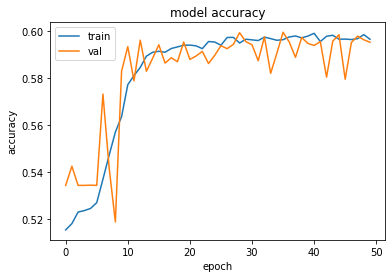

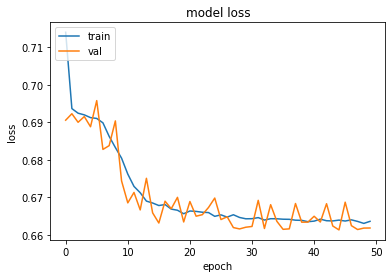

In [221]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [223]:
## Evaluate the Deep Learning Model

# predict probabilities for test set
preds = model.predict(test_data[predictors], verbose=0)
y_true = test_data[response]

print("Deep Neural Network Model Results: \n")
print(confusion_matrix(y_true, preds > 0.5))
print(classification_report(y_true, preds > 0.5))
print("-------------------------------------------------------")
random_clf = DummyClassifier(strategy="uniform").fit(train_data[predictors],
                                                     train_data[response]).predict(test_data[predictors])
print("Uniformly Random Dummy Classifer Benchmark : \n")
print(confusion_matrix(y_true, random_clf))
print(classification_report(y_true, random_clf))
print("-------------------------------------------------------")

Deep Neural Network Model Results: 

[[2295 2497]
 [1668 3834]]
              precision    recall  f1-score   support

           0       0.58      0.48      0.52      4792
           1       0.61      0.70      0.65      5502

    accuracy                           0.60     10294
   macro avg       0.59      0.59      0.59     10294
weighted avg       0.59      0.60      0.59     10294

-------------------------------------------------------
Uniformly Random Dummy Classifer Benchmark : 

[[2337 2455]
 [2758 2744]]
              precision    recall  f1-score   support

           0       0.46      0.49      0.47      4792
           1       0.53      0.50      0.51      5502

    accuracy                           0.49     10294
   macro avg       0.49      0.49      0.49     10294
weighted avg       0.50      0.49      0.49     10294

-------------------------------------------------------


In [0]:
# save the model to disk
filename = 'deep_dota2_predictor.sav'
pickle.dump(model, open(filename, 'wb'))

In [0]:
files.download(filename)